In [1]:
#Import data mainpulation modules
import pandas as pd
import numpy as np

#Import graphing libraries
from matplotlib import pyplot as plt
import seaborn as sns; sns.set()

#Import prophet function fb prophet
from fbprophet import Prophet

#Import XGBoost
import xgboost as xgb

#Import time module to compute run time
import time

In [2]:
#Read data in
dat = pd.read_csv('../Data/bike_sharing_hourly.csv', parse_dates=['dteday'])

In [3]:
#Function to create train and test splits
def train_test_splits(dat, val_dates):
    
    '''
    Function that splits training data into training and validation 
    sets using an expanding window. 
    Inputs:       dat - Training data to be split
            val_dates - List of dates to create validation sets. Must include last month 
                        of training data
    Outputs: expanding_window_indices - List with tuples of train and validation set indices
    '''
    
    #Initialize counter
    pos = 0
    expanding_window_indices = []

    #Iterate over all values except the last in list of dates
    for date in val_dates[:-1]:
    
        #Create training set
        train = dat[ : date]
        val_len = len(val_dates) - 1 #Count starts from 0
    
        #Create variable to move to the next date
        next_date = pos+1 if (pos+1 < val_len) else val_len
    
        #Creat validation split
        val = dat[val_dates[next_date]]
    
        pos += 1#Update counter
    
        #Create train and test set indices
        expanding_window_indices.append([train.index, val.index])
        
    return expanding_window_indices   

In [4]:
#Functions to compute error metrics
def accuracy(pred, obs):
    
    '''
    Computes mean absolute percentage error
    Inputs: pred - Array of predicted/forecasted values
             obs - Array of actual values to be forecast
    Outputs: error_metrics - Dictionary with 3 values; RMSE, MAE, MAPE
    '''
    
    error_metrics = {}
    
    #Convert inputs to numpy arrays
    pred, obs = np.array(pred), np.array(obs)
    
    #Compute error metrics
    error_metrics['MAPE'] = np.mean(np.abs((obs - pred)/obs))*100
    error_metrics['RMSE'] = np.sqrt(np.mean((obs - pred)**2))
    error_metrics['MAE'] = np.mean(np.abs((obs - pred)))
    
    return error_metrics

In [5]:
#Function to reverse transformation
def back_transform(og_pred_counts, pred_log_cnt, c=1):
    
    '''
    Reverse log transformation using bias adjustment to get mean of forecast distributions
    Inputs: pred_log_cnt - Pandas series of predicted log counts
                       c - Integer representing constant added to log values to avoid 0
    Outputs:          w0 - Pandas series of bias adjusted back transformed counts        
    '''
    
    w0 = np.exp(pred_log_cnt - c)
    
    #Compute constant using MM correction factor
    D = np.mean(og_pred_counts) / np.mean(w0)
    w = w0*D
    
    return w

## Data Pre-processing

In [6]:
# Convert to datetime format
dat['dteday'] = pd.to_datetime(dat.dteday) + dat.hr.astype('timedelta64[h]')

In [7]:
#Make dteday dataframe's index
dat.set_index('dteday', drop=True, inplace=True)

In [8]:
#Create new column with a log of counts
dat['log_cnt'] = np.log(dat.cnt) + 1 #add constant to change 0's to 1's

In [9]:
#Create dummies for each categorical variable of interest
dat_with_dummies = pd.get_dummies(dat, 
                                  columns=['season', 'yr', 'mnth', 'hr', 'weekday', 
                                           'weathersit', ],
                                  prefix=['Qtr', 'Year', 'Month', 'Hour', 'Day', 
                                          'Weather_Sit'], 
                                 drop_first=True)

#Drop categorical columns
dat_with_dummies = dat_with_dummies.drop(['instant', 'temp', 'casual', 'registered', 'cnt'], 
                                         axis=1)

In [10]:
#Check newly formed dataframe
dat_with_dummies.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 17379 entries, 2011-01-01 00:00:00 to 2012-12-31 23:00:00
Data columns (total 53 columns):
holiday          17379 non-null int64
workingday       17379 non-null int64
atemp            17379 non-null float64
hum              17379 non-null float64
windspeed        17379 non-null float64
log_cnt          17379 non-null float64
Qtr_2            17379 non-null uint8
Qtr_3            17379 non-null uint8
Qtr_4            17379 non-null uint8
Year_1           17379 non-null uint8
Month_2          17379 non-null uint8
Month_3          17379 non-null uint8
Month_4          17379 non-null uint8
Month_5          17379 non-null uint8
Month_6          17379 non-null uint8
Month_7          17379 non-null uint8
Month_8          17379 non-null uint8
Month_9          17379 non-null uint8
Month_10         17379 non-null uint8
Month_11         17379 non-null uint8
Month_12         17379 non-null uint8
Hour_1           17379 non-null uint8
Hour_2      

In [11]:
#Dataframe with regressors
x = dat_with_dummies.drop(['log_cnt'], axis=1)
y = dat_with_dummies.loc[:,'log_cnt']

In [12]:
#Convert data into optimized form to call xgboost on
data_dmatrix = xgb.DMatrix(data=x,label=y)

/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/anaconda3/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


## Tuning XGBoost 

### Step 1: Create training and validation sets

In [13]:
#Dates to create validation sets on
v_dates = ['Aug 2012', 'Sep 2012', 'Oct 2012', 'Nov 2012']

In [14]:
#Split data into train and validation sets
split_indices = train_test_splits(dat, v_dates)

In [15]:
#Create train and validation sets
# i = 0
# x_train = x[x.index.isin(split_indices[i][0])]
# x_val = x[x.index.isin(split_indices[i][1])]

# #Split y
# y_train = y[y.index.isin(split_indices[i][0])]
# y_val = y[y.index.isin(split_indices[i][1])]

In [16]:
#Create grid of hyper parameters to tune
from sklearn.model_selection import ParameterGrid

#Dictionary of hyper parameters to tune
hyper_params = {'step' : [0.05, 0.1, 0.3],  
                'n_trees' : [1000,2000], 
                'cols' : [0.6, 0.8, 1]}

#Build grid
grid = list(ParameterGrid(hyper_params))
len(grid)

18

In [17]:
#Perform grid search and record MAE scores on each run
comb_mae = []
comb_log_mae = []
for comb in grid:
    #Create and train xgboost model
    reg = xgb.XGBRegressor(learning_rate=comb['step'], 
                           colsample_bytree=comb['cols'], 
                           objective='reg:linear', 
                           n_estimators=comb['n_trees'])

    #Compute MAE scores for each iteration
    mae_scores = []
    mae_log_scores = []
    for i in range(len(split_indices)):
        
        #Create train and validation sets
        x_train = x[x.index.isin(split_indices[i][0])]
        x_val = x[x.index.isin(split_indices[i][1])]

        #Split y
        y_train = y[y.index.isin(split_indices[i][0])]
        y_val = y[y.index.isin(split_indices[i][1])]
        
        #Fit model to data and use early stopping to avoid overfitting
        reg.fit(x_train, y_train,
                eval_set=[(x_train, y_train), (x_val, y_val)], 
                eval_metric=['mae'],
                early_stopping_rounds=50, #stop if no decrease in error after 50 consec rnds
                verbose=False) # Change verbose to True if you want to see it train
    
        #Predict log counts in validation set
        x_val_pred = reg.predict(x_val)
        
        #Compute count errors on original scale
        pred_og_scale = back_transform(
            og_pred_counts=dat[dat.index.isin(split_indices[i][1])].cnt, 
                                   pred_log_cnt=x_val_pred)
        og_val_cnt = dat[dat.index.isin(split_indices[i][1])].cnt
    
        #Validation set accuracies of log and back transformed counts
        acc = accuracy(x_val_pred, y_val)
        acc_bkt = accuracy(pred_og_scale, og_val_cnt)
        
        mae_log_scores.append(acc['MAE'])
        mae_scores.append(acc_bkt['MAE'])
        
    print(mae_scores)    
    #Average MAE score over all folds and insert it into initial list   
    avg_mae_score = np.mean(mae_scores)
    comb_mae.append(avg_mae_score)
    
    avg_mae_log_score = np.mean(mae_log_scores)
    comb_log_mae.append(avg_mae_log_score)

[41.603251449929346, 48.339062980676104, 45.911450266838074]
[36.654180859857135, 44.96200728955242, 40.96356903045623]
[35.59556927747197, 43.19026929779915, 39.4489638943194]
[35.94484875202179, 44.98131117376231, 41.53273695657512]
[34.84511716498269, 42.49649275460486, 38.250831391153895]
[35.59556927747197, 42.87504720856241, 39.4489638943194]
[40.945723189910254, 47.97458181408165, 44.97921276225353]
[36.854008147451616, 44.32650131963741, 38.6161454527491]
[35.15088622801834, 42.4533563081154, 42.75179559722916]
[37.33158345686065, 45.41151965977782, 42.13848970975717]
[35.88770021001498, 42.32347921159981, 36.68746903646623]
[35.15088622801834, 42.559570093612884, 42.759881228291555]
[41.11017493075795, 47.64494737023014, 44.33608334609061]
[38.30427937540743, 44.79274668767627, 41.61018592102614]
[38.33825639486313, 44.75127846474028, 39.01689222197679]
[37.96687291463216, 44.466207938005695, 40.22993300884215]
[37.80776687396897, 44.79274668767627, 39.288128920584334]
[38.338

In [18]:
np.min(comb_mae)
comb_mae

[45.28458823248118,
 40.85991905995526,
 39.411600823196835,
 40.81963229411974,
 38.53081377024714,
 39.30652679345126,
 44.63317258874847,
 39.932218306612704,
 40.118679377787636,
 41.62719760879855,
 38.29954948602701,
 40.1567791833076,
 44.363735215692905,
 41.56907066136995,
 40.702142360526736,
 40.88767128716,
 40.629547494076526,
 40.33312250931369]

In [19]:
#Get values of optimal parameters
min_mae_index = comb_mae.index(min(comb_mae))
opt_comb = grid[min_mae_index]
opt_comb

{'cols': 0.8, 'n_trees': 2000, 'step': 0.1}

## Test Optimal Parameter Combination

In [20]:
#Split x and y 
x_train = x[x.index <= '30-Nov-2012']
x_test = x[x.index > '30-Nov-2012']

#Split y
y_train = y[y.index <= '30-Nov-2012']
y_test = y[y.index > '30-Nov-2012']

In [21]:
#Start timer
start_time = time.time()

In [22]:
#Create and train xgboost model
reg = xgb.XGBRegressor(learning_rate=opt_comb['step'],  
                       colsample_bytree=opt_comb['cols'], 
                       objective='reg:linear', 
                       n_estimators=opt_comb['n_trees'])

#Fit model to data
reg.fit(x_train, y_train,
        eval_set=[(x_train, y_train), (x_test, y_test)],
        eval_metric=['mae'],
        early_stopping_rounds=50, #stop if 50 consequent rounds without decrease of error
        verbose=False) # Change verbose to True if you want to see it train

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, importance_type='gain',
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=2000, n_jobs=1,
       nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1)

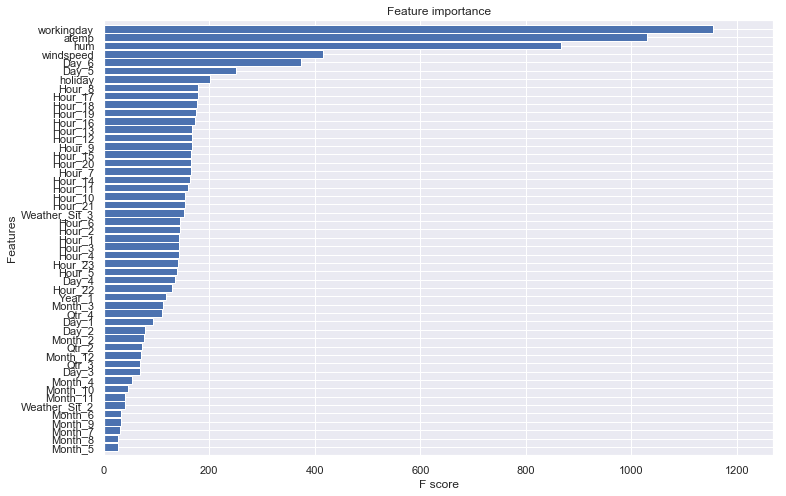

In [23]:
#Create feature importance plot
fig, ax = plt.subplots(figsize=(12, 8))
xgb.plot_importance(reg, height=0.9, 
                   show_values=False, ax=ax)
#plt.savefig('xgb_feature_importance.pdf')

In [24]:
#Predict counts in training set
x_train_pred = reg.predict(x_train)

In [25]:
#Predict counts in test set
x_test_pred = reg.predict(x_test)

## Measure Accuracy

In [26]:
#Train set log count accuracy
accuracy(x_train_pred, y_train)

{'MAPE': 5.902260947191095,
 'RMSE': 0.33900571721829054,
 'MAE': 0.22748839106506566}

In [27]:
#Test set log count accuracy
accuracy(x_test_pred, y_test)

{'MAPE': 8.877889632032208,
 'RMSE': 0.5188820002744853,
 'MAE': 0.35528015742521774}

In [28]:
#Get accuracy scores for training set
tr_pred_og_scale = back_transform(og_pred_counts=dat[dat.index <= '30-Nov-2012'].cnt, 
                                   pred_log_cnt=x_train_pred)
og_train_cnt = dat[dat.index <= '30-Nov-2012'].cnt

accuracy(tr_pred_og_scale, og_train_cnt)

{'MAPE': 26.82341153367155,
 'RMSE': 42.78736077227726,
 'MAE': 26.57391074073075}

In [29]:
#Convert predictions to original scale
pred_og_scale = back_transform(og_pred_counts=dat[dat.index > '30-Nov-2012'].cnt, 
                                   pred_log_cnt=x_test_pred)
og_test_cnt = dat[dat.index > '30-Nov-2012'].cnt

accuracy(pred_og_scale, og_test_cnt)

{'MAPE': 52.11662072822383, 'RMSE': 58.8499845078205, 'MAE': 38.37679880896425}

/anaconda3/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


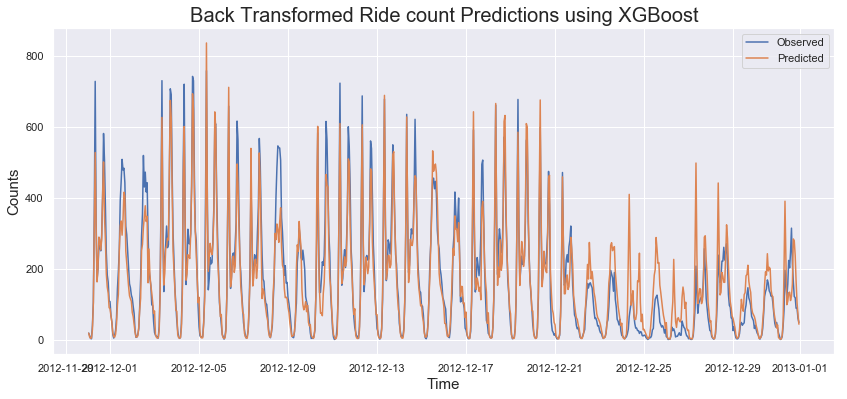

In [30]:
#Plot predictions and observed values
plt.figure(figsize=(14,6))
plt.plot(og_test_cnt.index, og_test_cnt, label='Observed')
plt.plot(og_test_cnt.index, pred_og_scale, label='Predicted')
plt.ylabel('Counts', size=15)
plt.xlabel('Time', size=15)
plt.title('Back Transformed Ride count Predictions using XGBoost', size = 20)
plt.legend()
#plt.savefig('../Pictures/Model_comparisons/xgb_tuned_og_predictions.pdf')

In [31]:
#End time
end_time = time.time()
run_time = (end_time - start_time)/60 #time in minutes
print('Total run time is', run_time, 'minutes')

Total run time is 1.2195664803187052 minutes


## Checking Model Residuals

Text(0, 0.5, 'Residuals')

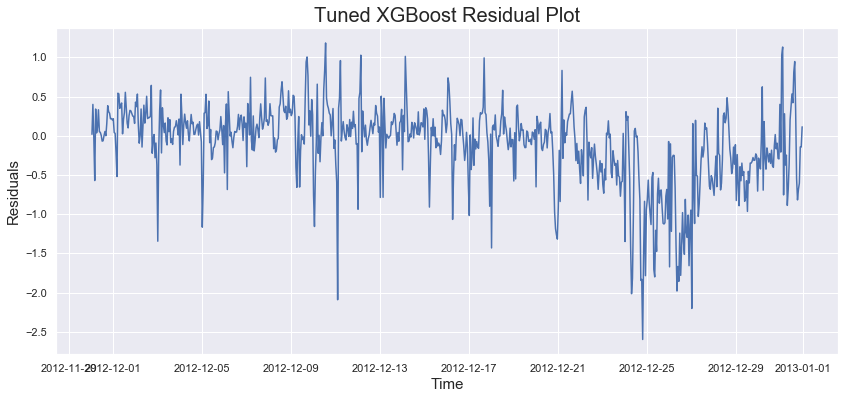

In [32]:
pred_residuals = (y_test-x_test_pred)
plt.figure(figsize=(14,6))
plt.plot(pred_residuals)
plt.title('Tuned XGBoost Residual Plot', size = 20)
plt.xlabel('Time', size=15)
plt.ylabel('Residuals', size=15)
#plt.savefig('../Pictures/Model_comparisons/xgb_tuned_og_resids.pdf')